In [1]:
%matplotlib notebook

import argparse
import torch
import matplotlib.pyplot as plt
from data import NoisyBSDSDataset
from argument import Args
from model import DnCNN, UDnCNN, DUDnCNN
import nntools as nt
from utils import DenoisingStatsManager, plot

In [2]:
args = Args()
args.plot = True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# dataset
train_set = NoisyBSDSDataset(
    args.root_dir, image_size=args.image_size, sigma=args.sigma)
test_set = NoisyBSDSDataset(
    args.root_dir, mode='test', image_size=args.test_image_size, sigma=args.sigma)

# model
if args.model == 'dncnn':
    net = DnCNN(args.D, C=args.C).to(device)
elif args.model == 'udncnn':
    net = UDnCNN(args.D, C=args.C).to(device)
elif args.model == 'dudncnn':
    net = DUDnCNN(args.D, C=args.C).to(device)
else:
    raise NameError('Please enter: dncnn, udncnn, or dudncnn')

# optimizer
adam = torch.optim.Adam(net.parameters(), lr=args.lr)

# stats manager
stats_manager = DenoisingStatsManager()

# experiment
exp = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=args.batch_size,
                    output_dir=args.output_dir, perform_validation_during_training=True)

cuda


<IPython.core.display.Javascript object>


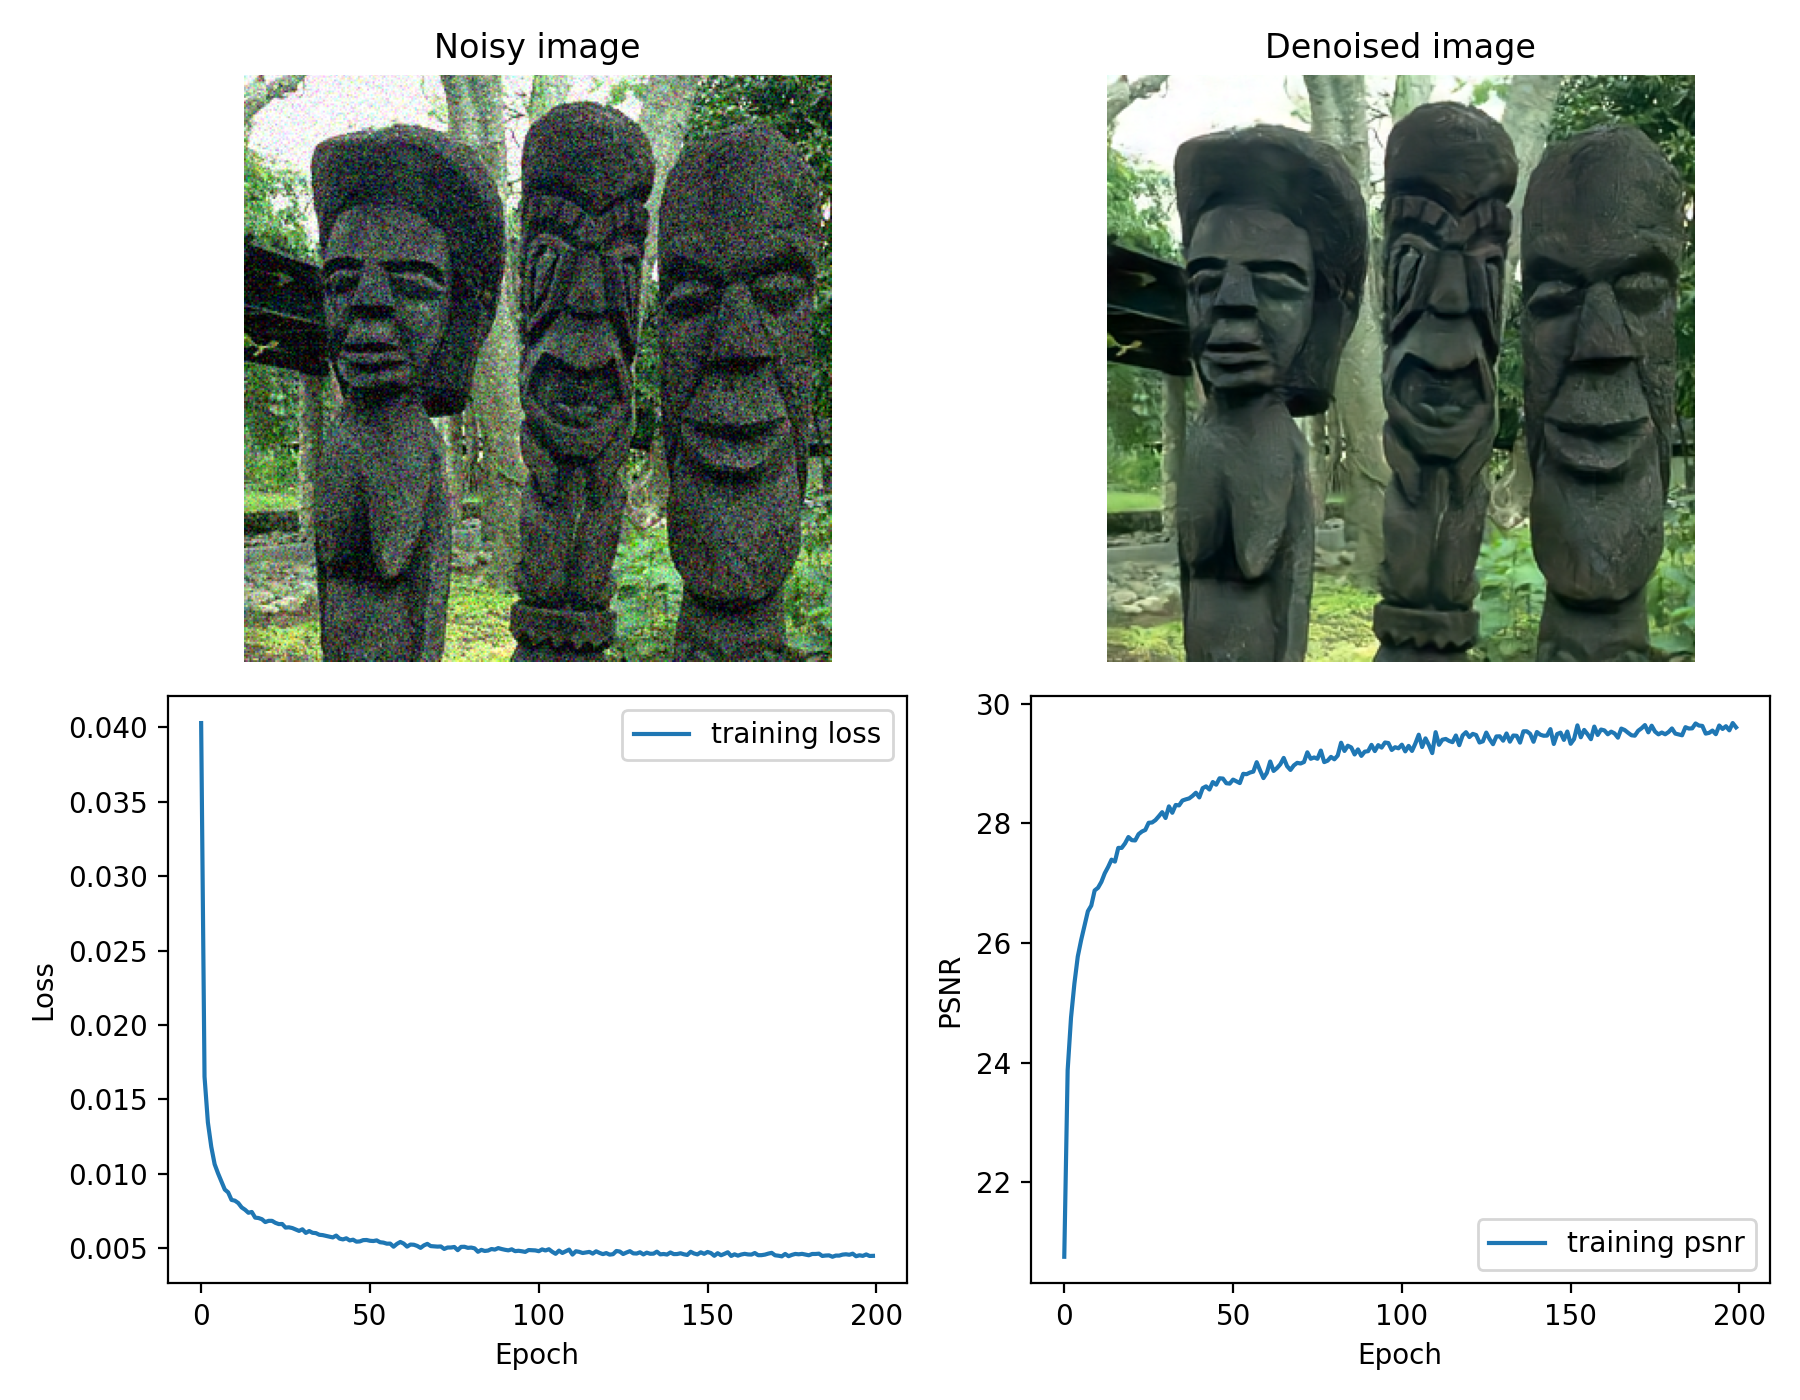

Start/Continue training from epoch 200
Finish training for 200 epochs


In [5]:
# run
if args.plot:
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
    exp.run(num_epochs=args.num_epochs, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))
else:
    exp.run(num_epochs=args.num_epochs)

## Testing on other image

In [6]:
from PIL import Image
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [8]:
def image_preprocess(img_path):
    img = Image.open(img_path).convert('RGB')  
    transform = tv.transforms.Compose([
        tv.transforms.Resize(300),
        # convert it to a tensor
        tv.transforms.ToTensor(),
        # normalize it to the range [−1, 1]
        tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    img = transform(img)
    return img

In [9]:
model = exp.net.to(device)
titles = ['origin', 'denoise']
img_path = "noisy25/0000.png"
x = image_preprocess(img_path=img_path)
img = []
img.append(x)
x = x.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])

<IPython.core.display.Javascript object>


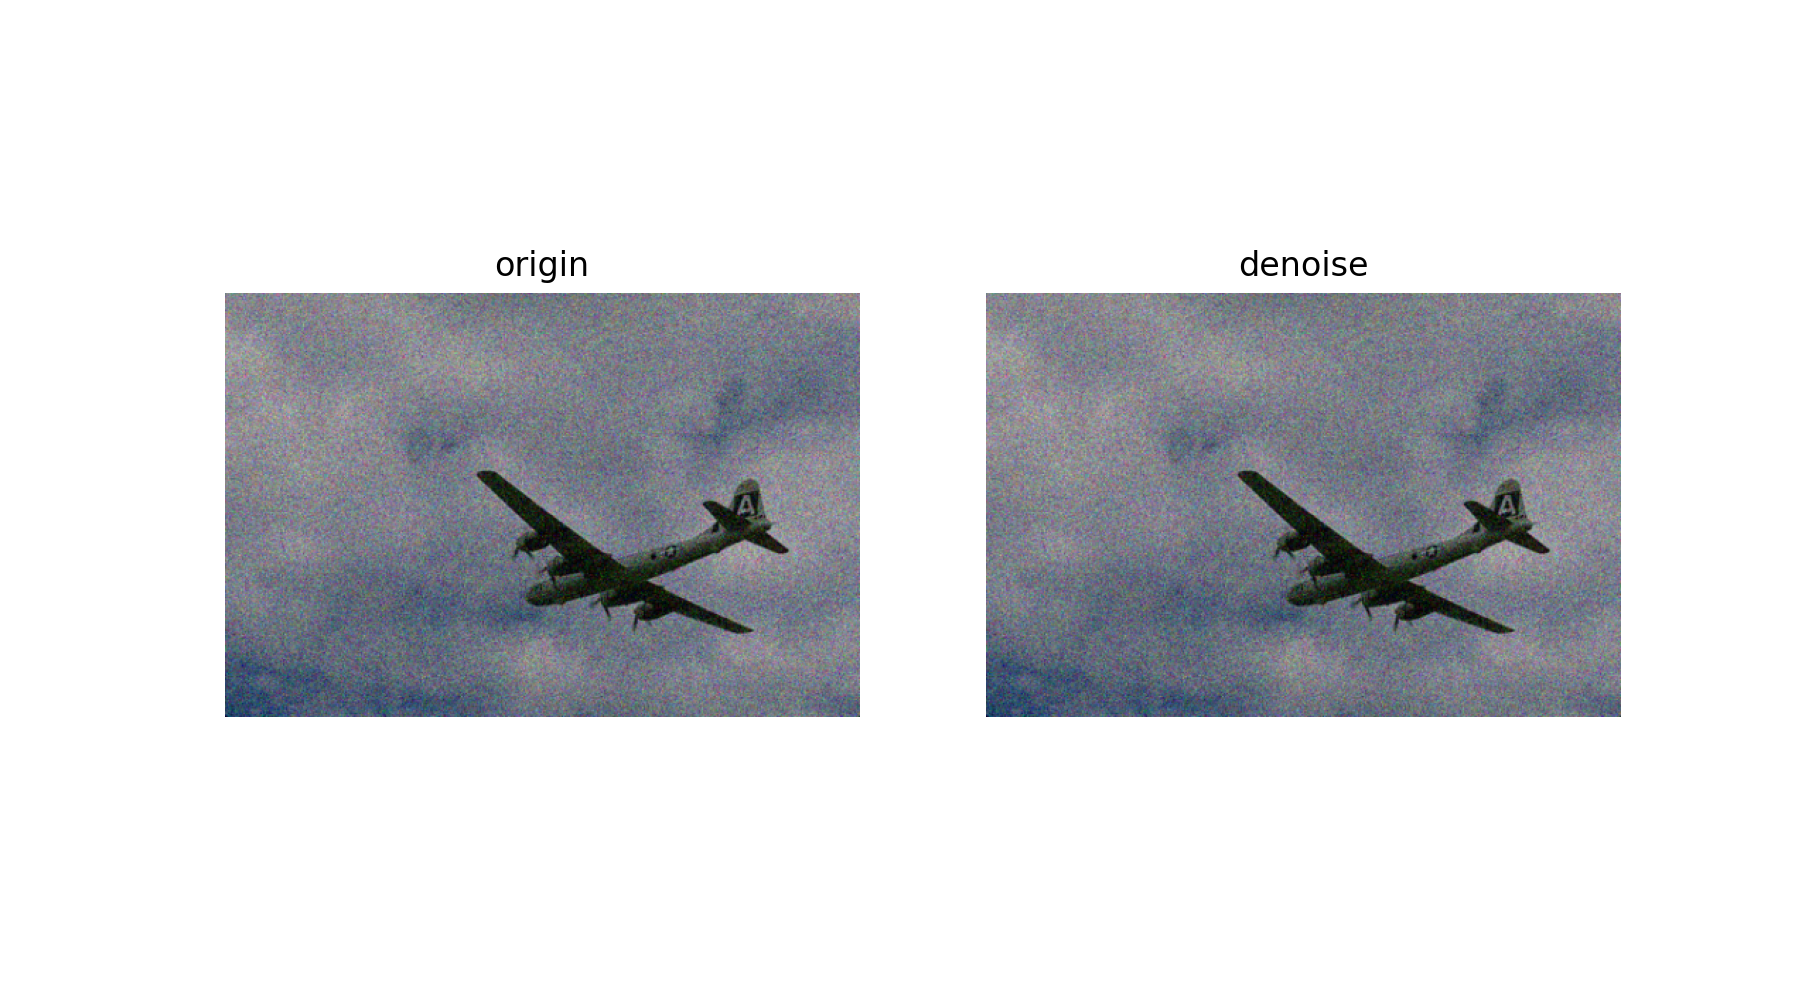

In [10]:
fig, axes = plt.subplots(ncols=len(img), figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

In [33]:
import cv2
from skimage.metrics import structural_similarity as ssim
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err
def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB,multichannel=True)
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()

In [23]:
image = img[0].to('cpu').numpy()
image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
image = (image + 1) / 2
image[image < 0] = 0
image[image > 1] = 1

In [25]:
image1 = img[1].to('cpu').numpy()
image1 = np.moveaxis(image1, [0, 1, 2], [2, 0, 1])
image1 = (image1 + 1) / 2
image1[image1 < 0] = 0
image1[image1 > 1] = 1

In [26]:
image.shape

(300, 449, 3)

<IPython.core.display.Javascript object>


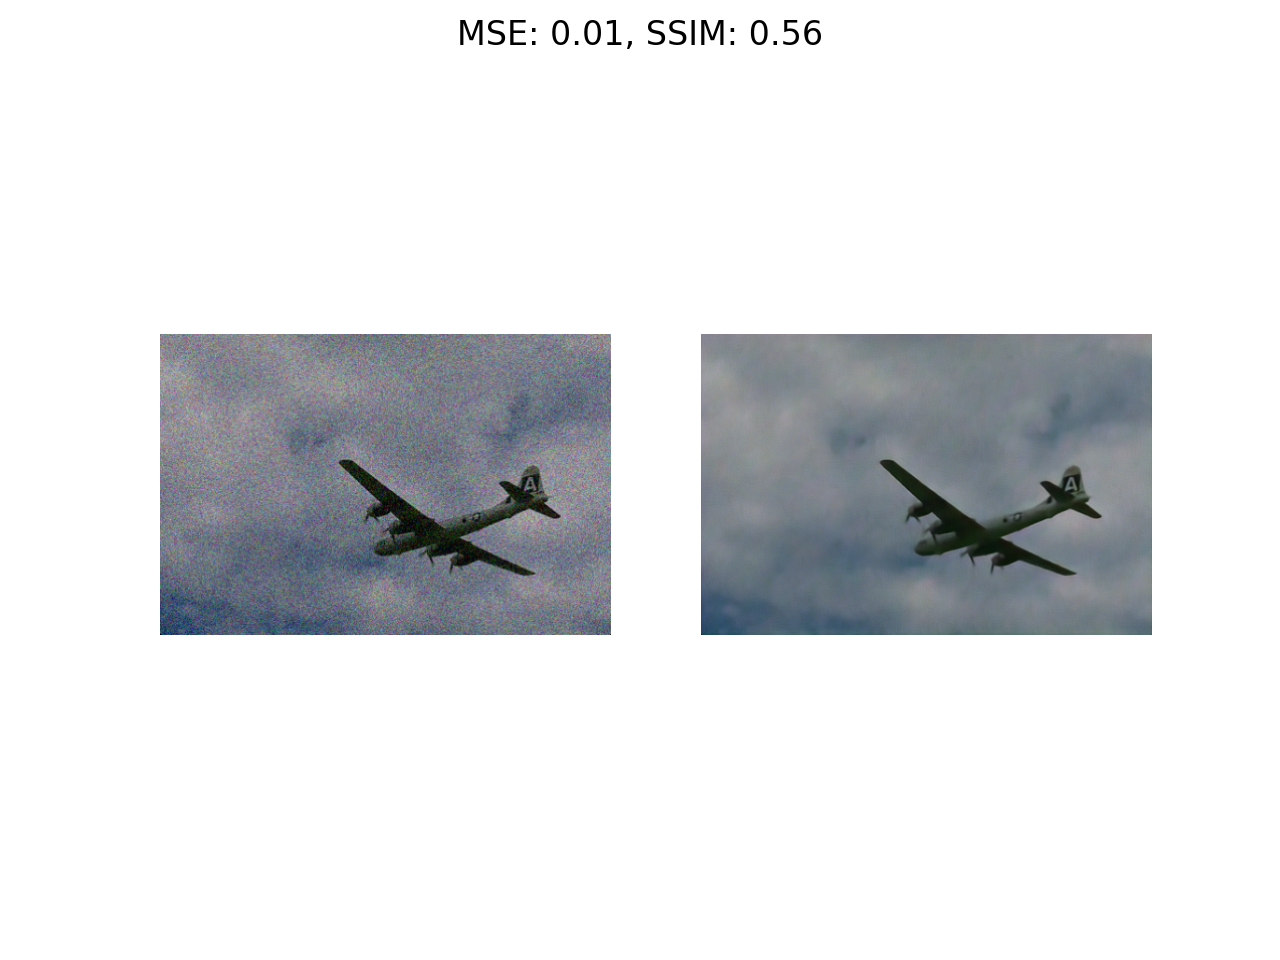

In [34]:
compare_images(image, image1, "Original vs. Denoise")